In [1]:
import pandas as pd
import numpy as np
import pickle
import altair as alt
from aoc import timeit
%load_ext autoreload
%autoreload 2

def save(model, filename='bestmodel.pickle'):
    with open('output/'+filename, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

def save_feature_selection(cols, filename='feat_selection.pickle'):
    with open('output/'+filename, 'wb') as handle:
        pickle.dump(cols, handle, protocol=pickle.HIGHEST_PROTOCOL)

def submit(model):
    pred = model.predict(final_test)
    final_test['SalePrice'] = np.exp(pred)
    final_test[['Id','SalePrice']].to_csv('output/submission.csv', index=False)

## Import data

In [2]:
f = open("output/engineered_datasets.pickle","rb")
train_x, train_y, final_test, num_x, cat_x, cat_x_ind = pickle.load(f)
f = open("output/feat_selection.pickle","rb")
cols = pickle.load(f)

## Import preprocessing pipelines & models

In [3]:

from utils.sklearn_custom_steps import DFSimpleImputer, DFOneHotEncoder,DFMinMaxScaler,DFColumnTransformer,DFOutlierExtractor,DFOutlierExtractor,DFStandardScaler,DFRobustScaler,DFSmartImputer, DFUnSkewer
from utils.sklearn_custom_steps import get_pipeline
from utils.model_hyperparameters import models

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet,SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import cross_validate
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from utils.model_hyperparameters import AutoCatBoostRegressor

## CV methods

In [4]:
def cross_val_models(to_test,train_x=train_x,**kwargs):
    for name in to_test:
        print(f"{name.ljust(20)}", end = ': ')
        pipe = get_pipeline(models[name].model, **models[name].preprocess, **kwargs)
        test_pipeline(pipe, train_x = train_x)
         
def test_model(model,train_x = train_x,param=None):
    if not param: param = {}
    pipe = get_pipeline(model,**param)
    return test_pipeline(pipe, train_x=train_x)

def test_pipeline(pipe,train_x = train_x):
    # print(train_x.shape)
    num_fold = 5
    scores = cross_validate(pipe, train_x, train_y, scoring='neg_root_mean_squared_error', cv=num_fold, return_train_score=True)
    print(f"test {-1 * sum(scores['test_score'])/num_fold:.7f}, train {-1 * sum(scores['train_score'])/num_fold:.7f}")
    return pipe

## Trying to hyperparameter search on preprocessing pipeline
This is not very succesful, since CV variance on small dataset is quite large. Idea is to run it multiple times with different random seeds

In [10]:
model = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.02, n_estimators=500,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,random_state=42)

model = Lasso(alpha=0.0005304432735934807)
pipe = get_pipeline(model,remove_outliers=True,unskew=True)
param_grid = {
   # 'preprocess__col_trans__category_cat_to_num': [DFOneHotEncoder(handle_unknown="ignore")],
   'preprocess__col_trans__numeric__unskew_num' : [DFUnSkewer(),'passthrough'],
   'preprocess__col_trans__numeric__scale_num' : [DFStandardScaler(),DFRobustScaler(),DFMinMaxScaler()],
   'preprocess__col_trans__numeric__impute_num__strategy': ['mean','median','most_frequent'],
   'preprocess__col_trans__category__impute_cat__strategy': ['most_frequent','constant'],
   'model':
      [DFOutlierExtractor(model,thres=-20000),
      DFOutlierExtractor(model,contamination=0.005),
      DFOutlierExtractor(model,contamination=0.01),]
   }
search = GridSearchCV(pipe, param_grid, cv=5,scoring='neg_root_mean_squared_error',verbose=1).fit(train_x, train_y)
frame =pd.DataFrame(search.cv_results_)
frame.sort_values(by='rank_test_score', inplace=True)
pd.set_option('display.max_colwidth', -1)

search.best_params_,search.best_score_

({'model': DFOutlierExtractor thres -1.5, cont 0.005,
  'preprocess__col_trans__category__impute_cat__strategy': 'constant',
  'preprocess__col_trans__numeric__impute_num__strategy': 'mean',
  'preprocess__col_trans__numeric__scale_num': DFStandardScaler,
  'preprocess__col_trans__numeric__unskew_num': DFUnSkewer},
 -0.10784594066649)

for Lasso:

    ({'model': DFOutlierExtractor thres -1.5, cont 0.005,
  'preprocess__col_trans__category__impute_cat__strategy': 'constant',
  'preprocess__col_trans__numeric__impute_num__strategy': 'mean',
  'preprocess__col_trans__numeric__scale_num': DFStandardScaler,
  'preprocess__col_trans__numeric__unskew_num': DFUnSkewer},
 -0.10784594066649)

## Rough test of all models

In [5]:
to_test = [
    'AutoCatBoostRegressor',
    'KernelRidge',
    'Lasso',
    'xgb.XGBRegressor',
    'lgb.LGBMRegressor']
cross_val_models(to_test, train_x=train_x,remove_outliers=False)

AutoCatBoostRegressor:test 0.1105842, train 0.0336562
KernelRidge         :test 0.1127409, train 0.0803417
Lasso               :test 0.1098146, train 0.0943253
xgb.XGBRegressor    :test 0.1134956, train 0.0762248
lgb.LGBMRegressor   :test 0.1162478, train 0.0914375


In [66]:
cross_val_models(to_test, train_x=train_x[cols['accepted']],remove_outliers=False)

AutoCatBoostRegressor:test 0.1129964, train 0.0469378
KernelRidge         :test 0.1111775, train 0.1018009
Lasso               :test 0.1150658, train 0.1101218
xgb.XGBRegressor    :test 0.1172317, train 0.0868923
lgb.LGBMRegressor   :test 0.1207388, train 0.1027652


In [67]:
cross_val_models(to_test, train_x=train_x[set(cols['selected'])],remove_outliers=False)

AutoCatBoostRegressor:test 0.1099761, train 0.0372695
KernelRidge         :test 0.1087862, train 0.0873139
Lasso               :test 0.1074478, train 0.0994891
xgb.XGBRegressor    :test 0.1117928, train 0.0785794
lgb.LGBMRegressor   :test 0.1153818, train 0.0932390


In [ ]:
# cols['selected'] does best

## above is nice, but need to fix crossvalidation with remove_outliers = True

In [5]:
to_test = [
    'AutoCatBoostRegressor',
    'KernelRidge',
    'Lasso',
    'xgb.XGBRegressor',
    'lgb.LGBMRegressor']
cross_val_models(to_test, train_x=train_x,remove_outliers=False)

AutoCatBoostRegressor:test 0.1104644, train 0.0328798
KernelRidge         :test 0.1152116, train 0.0799415
Lasso               :test 0.1088574, train 0.0941077
xgb.XGBRegressor    :test 0.1134032, train 0.0765185
lgb.LGBMRegressor   :test 0.1165820, train 0.0907541


In [6]:
cross_val_models(to_test, train_x=train_x[cols['accepted']],remove_outliers=False)

AutoCatBoostRegressor:test 0.1144572, train 0.0451957
KernelRidge         :test 0.1116109, train 0.1015869
Lasso               :test 0.1151067, train 0.1098602
xgb.XGBRegressor    :test 0.1170909, train 0.0870366
lgb.LGBMRegressor   :test 0.1210077, train 0.1020821


In [7]:
cross_val_models(to_test, train_x=train_x[set(cols['selected'])],remove_outliers=False)

AutoCatBoostRegressor:test 0.1099434, train 0.0354626
KernelRidge         :test 0.1092569, train 0.0872101
Lasso               :test 0.1074031, train 0.0992163
xgb.XGBRegressor    :test 0.1132363, train 0.0788391
lgb.LGBMRegressor   :test 0.1166609, train 0.0925373


In [11]:
pipe= get_pipeline(Lasso(),remove_outliers=False)
pipe.fit(train_x,train_y)
pipe.predict(train_x)

array([12.02194951, 12.02194951, 12.02194951, ..., 12.02194951,
       12.02194951, 12.02194951])

In [8]:
cross_val_models(to_test, train_x=train_x,remove_outliers=False)

AutoCatBoostRegressor:

KeyboardInterrupt: 

In [ ]:
cross_val_models(to_test, train_x=train_x[cols['accepted']],remove_outliers=True)

In [ ]:
cross_val_models(to_test, train_x=train_x[cols['selected']],remove_outliers=True)

## Tune number of iterations for Catboost

In [32]:
from utils.model_hyperparameters import AutoCatBoostRegressor
pipe = get_pipeline(AutoCatBoostRegressor(silent=True))
x = pipe[:-1].fit_transform(train_x[:1000])
val_x = pipe[:-1].transform(train_x[1000:])
fitted = pipe.named_steps['model'].fit(x,train_y[:1000],eval_set=(
    val_x,train_y[1000:]))

In [73]:
# onehot in pipeline gives better result and is 5x faster than passing cat to catboost
with timeit(''): test_model(AutoCatBoostRegressor(silent=True),param={'onehot':True})

(1414, 177)
INFO:root:, time: 1.2184464852015178
test 0.1116285, train 0.0335589


In [54]:
lr = [0.01,0.03,0.05,0.08,0.1,0.12,0.15,0.2]
lr = [0.03,0.035,0.04,0.046077001839876175,0.05,0.05,0.06]

In [59]:

for l in lr:
    pipe = get_pipeline(AutoCatBoostRegressor(silent=True,learning_rate=l,use_best_model=True,random_seed=42,iterations=1200))
    x = pipe[:-1].fit_transform(train_x[:1000])
    val_x = pipe[:-1].transform(train_x[1000:])
    fitted = pipe.named_steps['model'].fit(x,train_y[:1000],eval_set=(
        val_x,train_y[1000:]))
    print(f'{l:.10f}, {fitted.get_best_iteration():.5f},{fitted.best_score_}')

0.0300000000, 1148.00000,{'learn': {'RMSE': 0.034270830420753594}, 'validation': {'RMSE': 0.1082158776900088}}
0.0350000000, 959.00000,{'learn': {'RMSE': 0.028597792254358566}, 'validation': {'RMSE': 0.10810391342626736}}
0.0400000000, 808.00000,{'learn': {'RMSE': 0.02585967598484225}, 'validation': {'RMSE': 0.1087534427303903}}
0.0460770018, 607.00000,{'learn': {'RMSE': 0.02089384253669725}, 'validation': {'RMSE': 0.10899765464229043}}
0.0500000000, 790.00000,{'learn': {'RMSE': 0.017480529885352945}, 'validation': {'RMSE': 0.10916605794959813}}
0.0500000000, 790.00000,{'learn': {'RMSE': 0.017480529885352945}, 'validation': {'RMSE': 0.10916605794959813}}
0.0600000000, 731.00000,{'learn': {'RMSE': 0.012825372002920131}, 'validation': {'RMSE': 0.1083015915748979}}


In [60]:
fits = {}
fits['learn'] = list(fitted.get_evals_result()['learn'].values())[0]
fits['validation'] = list(fitted.get_evals_result()['validation'].values())[0]
df = pd.DataFrame.from_dict(fits)
df.reset_index(inplace=True)
df =  df.melt('index',var_name= 'type',value_name='score')
fitted.get_evals_result()

alt.Chart(df).mark_line().encode(
    x='index',
    y='score',
    color='type',
)

alt.Chart(...)

## Hyperparameter tuning

In [8]:
from skopt import BayesSearchCV, callbacks
from skopt.space import Real, Categorical, Integer

TRAIN_TIME = 600
NUM_ITERATIONS = 150
NO_IMPROVEMENT_STOP_THRES = 25

def gen_opt_settings(model_name):
    model = {'model': [models[model_name].model]}
    for k,v in models[model_name].hyper.items():
        model['model__'+k] = v
    if models[model_name].hyper:
        return (model, NUM_ITERATIONS)
    else:
        return (model, 1)

def optimize_model(model_name,train_x = train_x):
    print('running', model_name)
    def no_improvement_detector(optim_result):
        score = opt.best_score_
        # print(optim_result.x)
        print(f"{'best score':15}{score}")
        if score > opt.train_status['current_score']:
            opt.train_status['current_score'] = score
            opt.train_status['not_improving'] = 0
        else:
            opt.train_status['not_improving'] += 1
            if opt.train_status['not_improving'] == opt.train_status['stop_thres']: return True
    checkpointsaver = callbacks.CheckpointSaver("output/" + model_name + "_skopt.pkl")
    deadlinestopper = callbacks.DeadlineStopper(TRAIN_TIME)

    opt = BayesSearchCV(
        get_pipeline(models[model_name].model, remove_outliers=True,**models[model_name].preprocess),
        [gen_opt_settings(model_name)],
        cv=5, 
        scoring = 'neg_root_mean_squared_error',
        return_train_score = True,
        random_state = 112,
        refit=False
        )
    opt.train_status = { 'current_score': -100, 'not_improving': 0, 'stop_thres' :NO_IMPROVEMENT_STOP_THRES}
    opt.fit(train_x,train_y, callback = [no_improvement_detector,checkpointsaver,deadlinestopper])
    return opt

def hashing(self): return 8398398478478 
CatBoostRegressor.__hash__ = hashing # otherwise skopt flips

to_test = [k for k in models]
to_test = [
    'RandomForestRegressor',
    'GradientBoostingRegressor',
    'AutoCatBoostRegressor',
    'ElasticNet',
    'svm.SVR',
    'KernelRidge',
    'Lasso',
    'xgb.XGBRegressor',
    'lgb.LGBMRegressor']
results = {}
for name in to_test:
    results[name] = optimize_model(name, train_x)
save(results,'hyperparam_tuning.pickle')

running RandomForestRegressor
best score     -0.13583322966859293
best score     -0.13583322966859293
best score     -0.13583322966859293
best score     -0.13583322966859293
best score     -0.13583322966859293
best score     -0.13583322966859293
best score     -0.13583322966859293
best score     -0.13583322966859293
best score     -0.13583322966859293
best score     -0.13583322966859293
best score     -0.13196466601019483
best score     -0.13196466601019483
best score     -0.13196466601019483
best score     -0.13196466601019483
best score     -0.13196466601019483
best score     -0.13112933186035805
best score     -0.13112933186035805
best score     -0.13112933186035805
best score     -0.13112933186035805
best score     -0.13112933186035805
best score     -0.13112933186035805
best score     -0.13112933186035805
best score     -0.13112933186035805
best score     -0.13112933186035805
best score     -0.13112933186035805
best score     -0.13112933186035805
best score     -0.1311293318603580

In [5]:
f = open("output/hyperparam_tuning.pickle","rb")
results = pickle.load(f)

In [6]:
#summarize tuning results
for model in results:
    best_run = results[model].cv_results_['rank_test_score'].index(1)
    mean_test_score = -1 * results[model].cv_results_['mean_test_score'][best_run]
    std_test_score = results[model].cv_results_['std_test_score'][best_run]
    mean_train_score = -1 * results[model].cv_results_['mean_train_score'][best_run]
    mean_score_time = results[model].cv_results_['mean_score_time'][best_run]
    best_params = results[model].best_params_
    print(f"{model:<30} Best score {mean_test_score:.4f} std {std_test_score:.4f} train {mean_train_score:.4f} time {mean_score_time:.4f}")

RandomForestRegressor          Best score 0.1311 std 0.0046 train 0.0714 time 0.1649
GradientBoostingRegressor      Best score 0.1149 std 0.0055 train 0.0511 time 0.1959
AutoCatBoostRegressor          Best score 0.1103 std 0.0051 train 0.0535 time 0.0755
ElasticNet                     Best score 0.1088 std 0.0048 train 0.0934 time 0.1955
svm.SVR                        Best score 0.1268 std 0.0065 train 0.0918 time 0.3942
KernelRidge                    Best score 0.1146 std 0.0059 train 0.0827 time 0.1023
Lasso                          Best score 0.1088 std 0.0048 train 0.0934 time 0.1505
xgb.XGBRegressor               Best score 0.1123 std 0.0050 train 0.0445 time 0.0941
lgb.LGBMRegressor              Best score 0.1136 std 0.0060 train 0.0723 time 0.0971


## Experimental runs

In [ ]:
model = test_model(GradientBoostingRegressor(n_estimators=2945,
                 learning_rate=0.05,
                   max_depth=3,
                   max_features='sqrt',
                   min_samples_leaf=5,
                   min_samples_split=12,
                   loss='huber'))

## Stacking best models from hyperparam

In [7]:
from sklearn.ensemble import StackingRegressor

def get_estimator(model_name):
    model = get_pipeline(models[model_name].model, remove_outliers=False,**models[model_name].preprocess)
    model.set_params(**results[model_name].best_params_)
    return model

to_stack_list = [
    'ElasticNet',
    'GradientBoostingRegressor',
    'AutoCatBoostRegressor',
    'xgb.XGBRegressor',
    'KernelRidge']

# to_stack_list = to_test
# to_stack = [(model_name, results[model_name].best_estimator_) for model_name in to_stack_list]
# to_stack = [(model_name, results[model_name].best_estimator_) for model_name in results]
to_stack = [(model_name, get_estimator(model_name)) for model_name in results]
model = StackingRegressor(to_stack, final_estimator = (LinearRegression()), passthrough = False)
num_fold = 5
scores = cross_validate(model, train_x[set(cols['selected'])], train_y, scoring='neg_root_mean_squared_error', cv=num_fold, return_train_score=True)
print(f"stacking model train {-1 * sum(scores['train_score'])/num_fold:.4f}, test {-1 * sum(scores['test_score'])/num_fold:.4f}")
model.fit(train_x[set(cols['selected'])],train_y)
save(model,'ensemble.pickle')

stacking model train 0.0713, test 0.1054


## Blending, to get rid of some of the overfitting

In [76]:
f = open("output/ensemble.pickle","rb")
model = pickle.load(f)

In [9]:
preds = [estimator.predict(final_test) for estimator in model.estimators_[1:]]
weights = np.array([0.1]*len(preds) + [(1-len(preds)*0.1)])
preds.append(model.predict(final_test))
print(len(preds))
# weigh the individual models with 0.1 and the stacked regressor with the remainder
weighted_preds = preds * weights[:, None]
final_preds = np.sum(weighted_preds,axis=0)
final_test['SalePrice'] = np.exp(final_preds)
final_test[['Id','SalePrice']].to_csv('output/blend_submission.csv', index=False)

9


## Saving

In [11]:
# model = get_pipeline(CatBoostRegressor(silent=True,cat_features=cat_x),onehot=False)
# model = model.fit(train_x,train_y)
submit(model)
save(model,'ensemble.pickle')

## FastAI
This first try didn't really give me good results

In [66]:
import fastai2
# from fastai2.tabular.all import *
f = open("output/engineered_datasets.pickle","rb")
train_x, train_y, final_test, num_x, cat_x, cat_x_ind = pickle.load(f)
df = train_x
df['SalePrice'] = train_y

In [67]:
num_x,cat_x = cont_cat_split(df, max_card=9000, dep_var='SalePrice')

In [69]:
dls = TabularDataLoaders.from_df(df, path='bla', y_names="SalePrice",
    cat_names = cat_x,
    cont_names = num_x,
    procs = [Categorify, FillMissing, Normalize])

In [70]:
learn = tabular_learner(dls, layers=[1000,500], loss_func=F.mse_loss, # or func MSELossFlat()
                        config=tabular_config(ps=[0.001,0.01], embed_p=0.04), 
                        metrics=rmse)

learn = tabular_learner(dls, loss_func=MSELossFlat(), 
                        metrics=rmse)

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.00363078061491251)

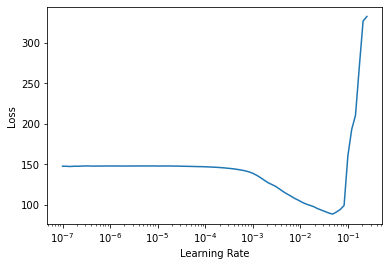

In [71]:
learn.lr_find()

In [87]:
learn.fit_one_cycle(15, 6.918309954926372e-05, wd=0.2)

epoch,train_loss,valid_loss,_rmse,time
0,0.720350,1.260966,1.122927,00:07
1,0.634628,1.274511,1.128943,00:06
2,0.633233,1.154903,1.074664,00:06
3,0.722872,1.229494,1.108825,00:06
4,0.635765,0.975592,0.987721,00:07
5,0.672587,1.005359,1.002676,00:06
6,0.610774,1.013499,1.006727,00:06
7,0.514983,0.915475,0.956805,00:06
8,0.512361,0.657616,0.810935,00:07
9,0.509264,0.903293,0.950417,00:06


In [88]:
final_test['BsmtFinSF1'] = final_test['BsmtFinSF1'].fillna(0)
final_test['BsmtFinSF2'] = final_test['BsmtFinSF2'].fillna(0)
final_test['BsmtUnfSF'] = final_test['BsmtUnfSF'].fillna(0)
final_test['TotalBsmtSF'] = final_test['TotalBsmtSF'].fillna(0)
final_test['BsmtFullBath'] = final_test['BsmtFullBath'].fillna(0)
final_test['KitchenQual'] = final_test['KitchenQual'].fillna(train_x['KitchenQual'].mean())
final_test['Functional'] = final_test['Functional'].fillna(train_x['Functional'].mean())
final_test['GarageCars'] = final_test['GarageCars'].fillna(0)
final_test['GarageArea'] = final_test['GarageArea'].fillna(0)
final_test['SimplFunctional'] = final_test['SimplFunctional'].fillna(0)
final_test['SimplKitchenQual'] = final_test['SimplKitchenQual'].fillna(0)
final_test['KitchenScore'] = final_test['KitchenScore'].fillna(0)
final_test['SimplFunctional'] = final_test['SimplFunctional'].fillna(train_x['SimplFunctional'].mean())
final_test['SimplKitchenScore'] = final_test['SimplKitchenScore'].fillna(train_x['SimplKitchenScore'].mean())
final_test['TotalBath'] = final_test['TotalBath'].fillna(1)
final_test['AllSF'] = final_test['AllSF'].fillna(train_x['AllSF'].mean())
final_test['AllSF_2'] = final_test['AllSF_2'].fillna(train_x['AllSF_2'].mean())
final_test['AllSF_3'] = final_test['AllSF_3'].fillna(train_x['AllSF_3'].mean())
final_test['AllSF_sq'] = final_test['AllSF_sq'].fillna(train_x['AllSF_sq'].mean())
final_test['GarageCars_2'] = final_test['GarageCars_2'].fillna(train_x['GarageCars_2'].mean())
final_test['GarageCars_3'] = final_test['GarageCars_3'].fillna(train_x['GarageCars_3'].mean())
final_test['GarageCars_sq'] = final_test['GarageCars_sq'].fillna(train_x['GarageCars_sq'].mean())
final_test['TotalBath_2'] = final_test['TotalBath_2'].fillna(train_x['TotalBath_2'].mean())
final_test['TotalBath_3'] = final_test['TotalBath_3'].fillna(train_x['TotalBath_3'].mean())
final_test['TotalBath_sq'] = final_test['TotalBath_sq'].fillna(train_x['TotalBath_sq'].mean())
final_test['TotalBath_sq'] = final_test['TotalBath_sq'].fillna(train_x['TotalBath_sq'].mean())
final_test['KitchenQual_2'] = final_test['KitchenQual_2'].fillna(train_x['KitchenQual_2'].mean())
final_test['KitchenQual_3'] = final_test['KitchenQual_3'].fillna(train_x['KitchenQual_3'].mean())
final_test['KitchenQual_sq'] = final_test['KitchenQual_sq'].fillna(train_x['KitchenQual_sq'].mean())
final_test['BsmtFinSF1_log'] = final_test['BsmtFinSF1_log'].fillna(train_x['BsmtFinSF1_log'].mean())
final_test['BsmtFinSF2_log'] = final_test['BsmtFinSF2_log'].fillna(train_x['BsmtFinSF2_log'].mean())
final_test['BsmtUnfSF_log'] = final_test['BsmtUnfSF_log'].fillna(train_x['BsmtUnfSF_log'].mean())
final_test['TotalBsmtSF_log'] = final_test['TotalBsmtSF_log'].fillna(train_x['TotalBsmtSF_log'].mean())
final_test['BsmtFullBath_log'] = final_test['BsmtFullBath_log'].fillna(train_x['BsmtFullBath_log'].mean())
final_test['TotalBsmtSF_log'] = final_test['TotalBsmtSF_log'].fillna(train_x['TotalBsmtSF_log'].mean())
final_test['BsmtHalfBath_log'] = final_test['BsmtHalfBath_log'].fillna(train_x['BsmtHalfBath_log'].mean())
final_test['GarageCars_log'] = final_test['GarageCars_log'].fillna(train_x['GarageCars_log'].mean())
final_test['GarageArea_log'] = final_test['GarageArea_log'].fillna(train_x['GarageArea_log'].mean())
final_test['AllSF_log'] = final_test['AllSF_log'].fillna(train_x['AllSF_log'].mean())
final_test['BsmtHalfBath'] = final_test['BsmtHalfBath'].fillna(train_x['BsmtHalfBath'].mean())

# test_to = to.new(final_test)
# test_to.process()

In [89]:
final_test['MiscFeature']=np.nan
dl = learn.dls.test_dl(final_test)
res= learn.get_preds(dl=dl)

In [90]:
final_test['SalePrice'] = np.exp(res[0].numpy())
final_test[['Id','SalePrice']].to_csv('output/submission.csv', index=False)

In [91]:
final_test['SalePrice'][:100]

0      67190.859375
1      16630.333984
2      49383.144531
3      77657.109375
4     110854.671875
          ...      
95     55282.664062
96     88132.164062
97     85025.382812
98     67225.734375
99     12819.370117
Name: SalePrice, Length: 100, dtype: float32

## Borutashap for feature selection
Let it run for n_trials. After a dictionary is returned with:
- accepted: columns with information
- tentative: not sure yet
- rejected: columns not better than max shadow
- selected: accepted + tentative

https://medium.com/analytics-vidhya/is-this-the-best-feature-selection-algorithm-borutashap-8bc238aa1677

In [16]:
f = open("output/engineered_datasets.pickle","rb")
train_x, train_y, final_test, num_x, cat_x, cat_x_ind = pickle.load(f)

from BorutaShap import BorutaShap
from utils.model_hyperparameters import AutoCatBoostRegressor
cat = CatBoostRegressor(max_depth=5,silent=True)

# with onehot = False, this leads to lower amount of columns. But a CatBoostRegressor does need way more time to do the onehot encoding manually
# however it's very nice to see the categorical columns
pipe = get_pipeline(BorutaShap(model = cat, importance_measure='shap',
                              classification=False, pvalue=0.005),onehot=False)
feat_selector = pipe.fit(train_x,train_y,model__n_trials=50)

100%|██████████| 50/50 [45:15<00:00, 54.32s/it]30 82 98 (accept,tentative,reject)
30 attributes confirmed important: ['TotalBath_2', 'AllSF_sq', 'OverallGrade', 'OverallQual_3', 'Neighborhood', 'OverallQual_2', 'LotArea_log', 'MSZoning', 'YearRemodAdd_log', 'LotArea', 'YearBuilt', 'BsmtExposure', 'AllSF_2', 'CentralAir', 'SaleCondition', 'TotalBath_sq', 'OverallQual_sq', 'TotalSF_log', 'GarageFinish', 'AllSF_3', 'AllSF', 'OverallQual', 'GarageYrBlt', 'AllPorchSF', 'Total_sqr_footage', 'OverallCond', 'TotalSF', 'Condition1', 'SimplOverallQual', 'YrBltAndRemod']
98 attributes confirmed unimportant: ['Heating', 'Exterior2nd', 'PoolArea', 'FireplaceScore', 'FullBath_log', 'BedroomAbvGr_log', 'TotRmsAbvGrd_log', 'LowQualFinSF_log', 'MasVnrType', 'ExterGrade', 'SimplGarageCond', 'YrSold', 'GarageScore_sq', 'has2ndfloor', 'BsmtFinType1', 'MiscVal_log', 'EnclosedPorch', 'Condition2', 'MiscFeature', 'PavedDrive', 'GarageScore_3', 'LotShape', 'LotFrontage', 'ScreenPorch_log', 'PoolArea_log', 'MS

In [24]:
feat_selector

Pipeline(memory=None,
         steps=[('preprocess',
                 Pipeline(memory=Memory(location=C:\Users\Jesse\AppData\Local\Temp\tmpf97qfzq2\joblib),
                          steps=[('col_trans',
                                  DFColumnTransformer(n_jobs=None,
                                                      remainder='drop',
                                                      sparse_threshold=0.3,
                                                      transformer_weights=None,
                                                      transformers=[('numeric',
                                                                     Pipeline(memory=None,
                                                                              steps=[('impute_num',
                                                                                      DFSimpleImputer(add_indicator=False, copy...
                                                                     Pipeline(memory=None,
        

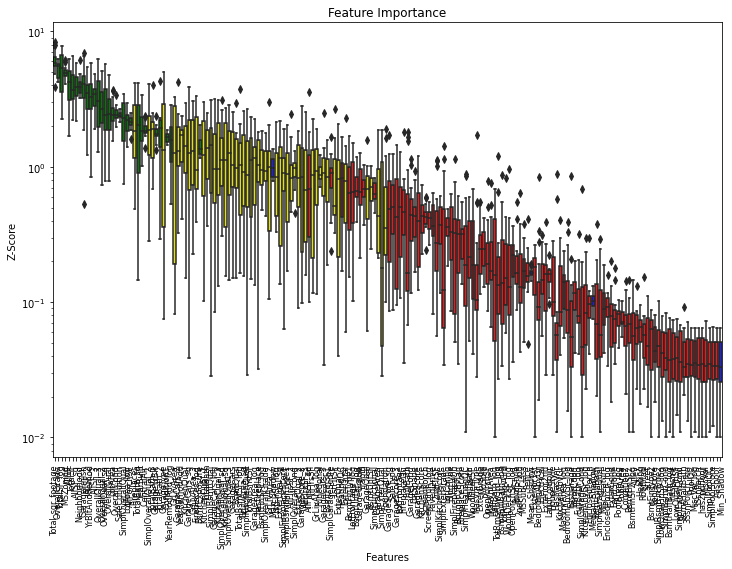

In [28]:
feat_selector.named_steps['model'].plot(which_features='all', 
                      X_size=8, figsize=(12,8),
                      y_scale='log')

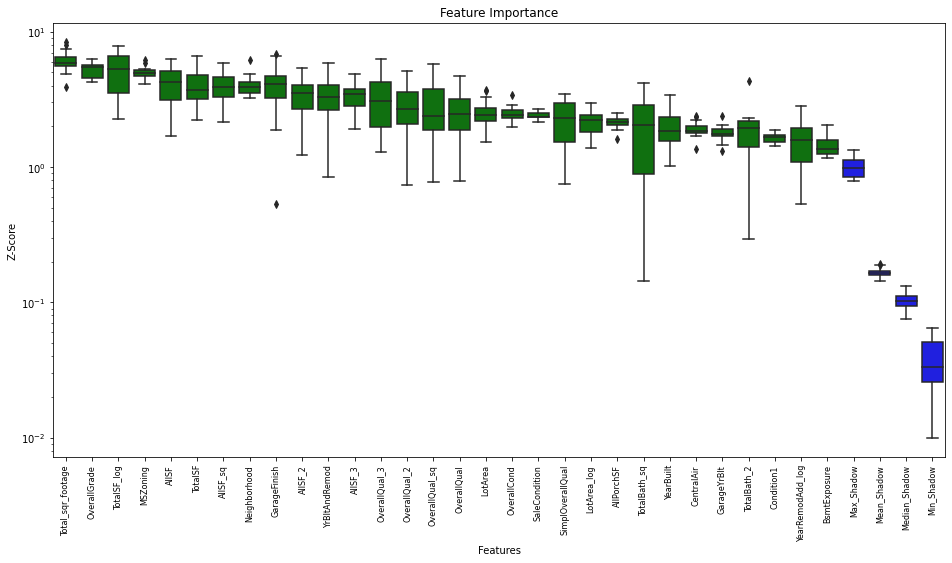

In [25]:
feat_selector.named_steps['model'].plot(which_features='accepted', 
                      X_size=8, figsize=(16,8),
                      y_scale='log')

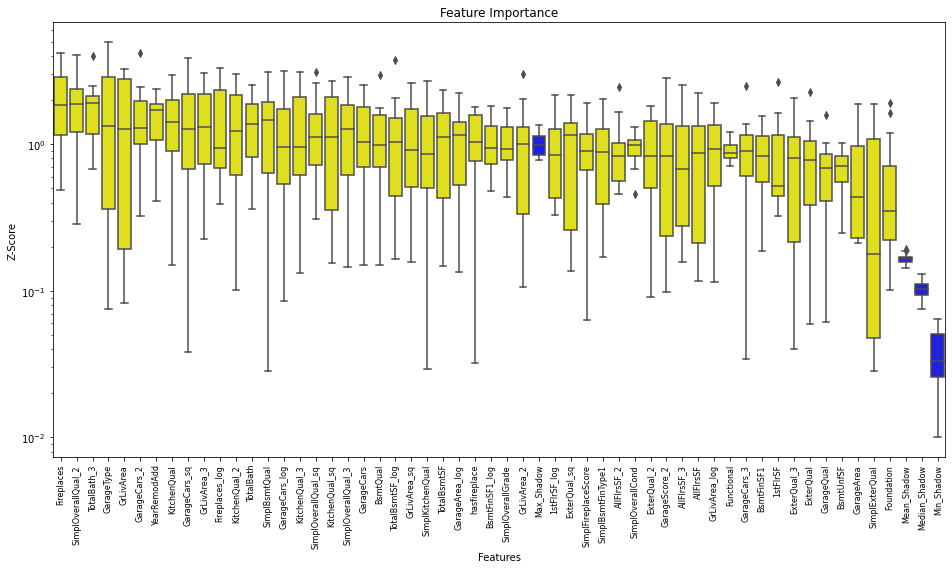

In [27]:
feat_selector.named_steps['model'].plot(which_features='tentative', 
                      X_size=8, figsize=(16,8),
                      y_scale='log')

In [60]:
# check which run works best. Note that CV has quite high variance 
to_test = [lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.02, n_estimators=500,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,random_state=42),
            Lasso(alpha=0.0005304432735934807)]
for model in to_test:
    print('baseline')
    test_model(model,train_x=train_x)
    for i in [16,26,49]:
        cols = feat_selector.named_steps['model'].runs[i]['accepted']
        print('run',i, 'num cols',len(cols), end=':')
        test_pipeline(get_pipeline(Lasso(alpha=0.0005304432735934807)),train_x=train_x[cols])


baseline
test 0.1161553, train 0.0915574
run 16 num cols 20:test 0.1236468, train 0.1188461
run 26 num cols 25:test 0.1150658, train 0.1101218
run 49 num cols 30:test 0.1147539, train 0.1095006
baseline
test 0.1098146, train 0.0943253
run 16 num cols 20:test 0.1236468, train 0.1188461
run 26 num cols 25:test 0.1150658, train 0.1101218
run 49 num cols 30:test 0.1147539, train 0.1095006


In [61]:
for model in to_test:
    print('baseline')
    test_model(model,train_x=train_x)
    for i in [16,26,49]:
        cols = set(feat_selector.named_steps['model'].runs[i]['selected'])
        print('run',i, 'num cols',len(cols), end=':')
        test_pipeline(get_pipeline(Lasso(alpha=0.0005304432735934807)),train_x=train_x[cols])

baseline
test 0.1161553, train 0.0915574
run 16 num cols 106:test 0.1081994, train 0.0990112
run 26 num cols 92:test 0.1074478, train 0.0994891
run 49 num cols 82:test 0.1076702, train 0.1004430
baseline
test 0.1098146, train 0.0943253
run 16 num cols 106:test 0.1081994, train 0.0990112
run 26 num cols 92:test 0.1074478, train 0.0994891
run 49 num cols 82:test 0.1076702, train 0.1004430


In [62]:
cols = feat_selector.named_steps['model'].runs[26]
save(cols, filename='feat_selection.pickle')